# ロジスティック回帰

ベルヌーイ分布に従う変数の統計的回帰モデルの一種．主に二値分類で使われる．

---

In [1]:
import pandas as pd
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

シグモイド関数(ロジスティック)の式
$$
\sigma = \frac{1}{1-e^{-x}}
$$
このとき$x$に代入するのは単純な線形回帰の式である．

$$
x = X\bm{w}
$$

線形分離可能なデータセットを作成する．\
線形非分離な問題についても後で突っ込んでみたいね．
- 線形非分離
- from sklearn.datasets import make_gaussian_quantiles

参考
- https://plantprogramer.com/data_generator/

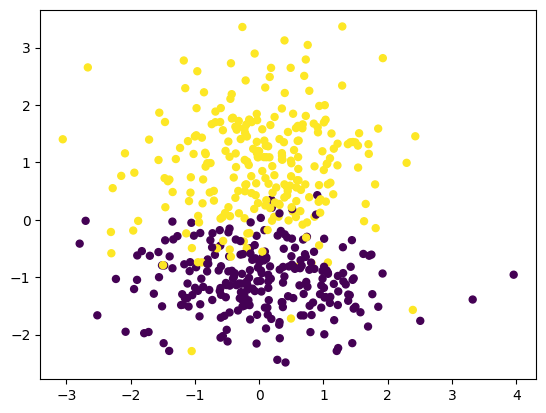

In [2]:
N = 500 #データの数
d = 2 # 次元数
K = 2 # クラス数

X, y = make_classification(
    n_samples=N,
    n_features=d,
    n_informative=1,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=K,
    random_state = 1
)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25) #c=yで色指定できる

In [3]:
model = LogisticRegression(
    penalty=None,
    dual=False,
    tol=0.0001, #誤差の許容値，勾配降下のときに使うのかな？
    C = 1.0, # 正則化の強さ
    fit_intercept= False,# バイアス項を入れるかどうか，どのように影響するかはよくわからない
    intercept_scaling= 1.0, # solver='liblinear'でfit_intercept=Trueのときに発動
    class_weight=None, # クラスの数に応じて重みを受けることができる．
    random_state=None, # solver=['sag','saga','liblinear']のときにデータをシャッフルする．
    solver='newton-cg', # newton-cg を実装したい
    max_iter=100,
    multi_class='auto',
    verbose=0, # 冗長と訳せる，確かいらない
    warm_start=False, # 前のソリューションの値をそのまま持ってくる，でない場合はただ初期化するだけ
    n_jobs=None, # 使用するcpuのコア数
    l1_ratio=None # elasticnetのときの正則化割合，l1の割合を操作できる．
    )

In [4]:
model.fit(X,y)
print('クラス数',model.classes_)
print('特徴量の数',model.n_features_in_)
print('coef',model.coef_)
print('intercept',model.intercept_)
print('反復数',model.n_iter_)

クラス数 [0 1]
特徴量の数 2
coef [[-0.05666067  3.28250233]]
intercept [0.]
反復数 [5]


In [5]:
pred = model.predict(X)
print(accuracy_score(y, pred))

0.918


- バイアス項の有無
- solverの違い

で出力が変わる．どう違うのかはよくわからん．

ロジスティック回帰の流れ．
- ただの線形回帰だと二値分類に適さない\
->0,1を求めたいのにそれより上or下の値を取るから．0より下は全て0で1より上は全て1のようになるのが適切．
- そこで使うのがロジスティック関数(シグモイド関数)
- シグモイド関数の$x$に線形回帰の式をそのまま代入．\
->出力は0から1の間に収まる，(これを予測確率として扱う)
- 求めるのはロジスティック関数の中の線形回帰の式のパラメータ$\bm{w}$
- パラメータ$\bm{w}$を点推定する．\
※ここで出てくる手法は最小二乗法ではない(最小二乗法は正規分布のデータに対してパラメータを推定する手法だから)
- 今回の目的変数は0,1だからこれは試行回数1回の二項分布，従ってベルヌーイ分布となる．
- 従ってここでは最尤推定を使う．(分布はなんでもいいので)
- 対数尤度をとる(計算しやすいから)
- 対数尤度をとっても代数的に，解析的に解を求めることができない．
- よって勾配降下でパラメータを求めていく．
- 従って今回はニュートン法(やってることは勾配降下法と変わらないが，二階微分を含むので計算量が多い)で解を求める．
---
対数尤度関数はもうある．\
対数尤度関数のパラメータ$P_i$を算出する式もある．\
それはロジスティック関数．(線形回帰の式が肩に乗っかった)\
しかし求めたいパラメータ$\beta$はわかっていないので，ここをニュートン法で求める．

今回の実装はバイアス項なし，かつnewton,newton-cg,lbfgsを実装したい．ようはパラメータの求め方だけ違うってこと．

ニュートン法
$$
\bm{w}^{new}=\bm{w}^{old}-H^{-1}\nabla E(\bm{w}^{old})
$$
これがパラメータの更新式．\
これを解いていくためには$H$，ヘッセ行列が必要である．\
ちなみに$\nabla E(\bm{w}^{old})$はただの一階微分

一旦，イメージが掴みやすいようにニュートン法によって$\sqrt{2}$の近似値を求めてみる．\
このときのニュートン法の式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$

In [6]:
# なぜか式を変数で指定すると収束しない．
# 適当な初期値の設定
x = 5.0

while True:

    # ニュートン法による新しいxを求める
    x2 =  x - (x * x - 2) / (x * 2)

    # 計算後の値が誤差の範囲内になったら計算終了
    if abs(x2 - x) < 0.0001:
        break

    # 計算後の値をxとして計算を繰り返す
    x = x2

# 計算結果の表示
print(x)



1.4142135857968836


ニュートン法のイメージが掴めた．ということで$\bm{w}^{new}$についても同様に理解したい．\
ニュートン法の式と今回使う式の対応を考えよう．\
今回の式は以下
$$
\bm{w}^{new}=\bm{w}^{old}-H^{-1}\nabla E(\bm{w}^{old})
$$
ニュートン法のわかりやすい式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$
一見何が対応しているのかわからないが，整理していく．\
$H^{-1}$はヘッセ行列(二階微分)の逆行列であり．$\frac{1}{f'(x_1)}$に対応する．$f'(x)^{-1}$と書くとわかりやすい．\
$\nabla E(\bm{w}^{old})$はただの一階微分であり，$f(x_1)$に対応する．\
整理できた．

今回は最終的に$\nabla E(\bm{w})\simeq 0$をニュートン法で目指す．

- tol
<!-- - solver -->
- max_iter

更新式は以下
$$
\bm{w}^{new} = \bm{w}^{old}-H^{-1}\Delta E (\bm{w}^{old})
$$
$$
\bm{w}^{new} = (X^TRX)^{-1}(X^TR)[X\bm{w}^{old}-R^{-1}(\hat{y}-y)]
$$

tolでbreakしないパターン

In [55]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    def _sigmoid(self, Xw): #ここなんでselfいるのー
        return 1 / (1 + np.exp(-Xw))

    def _predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        return self._sigmoid(y_hat_Xw)

    def _get_w(self, x, y, y_hat):
        for _ in range(X.shape[0]):
            self.R[_,_] = y_hat[_] * (1 - y_hat[_])
        xr = x.T @ self.R
        w_new = (np.linalg.pinv(xr @ x) @ (xr)) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
        return w_new

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        for i in range(self.max_iter):
            y_hat = self._predict(x)
            self.w = self._get_w(x, y, y_hat)

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

tolでちゃんとbreakするパターン

In [77]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    def _sigmoid(self, Xw): #ここなんでselfいるのー
        return 1 / (1 + np.exp(-Xw))

    def _predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        return self._sigmoid(y_hat_Xw)

    def _get_w(self, x, y, y_hat):
        for _ in range(X.shape[0]):
            self.R[_,_] = y_hat[_] * (1 - y_hat[_])
        xr = x.T @ self.R
        w_new = (np.linalg.pinv(xr @ x) @ (xr)) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
        w_return = w_new - self.w
        return w_new, w_return

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        for i in range(self.max_iter):
            y_hat = self._predict(x)
            w_new, diff = self._get_w(x, y, y_hat)
            if np.all(diff < tol_vec): #配列の要素全てがtolより小さいかったら
                break
            elif np.any(diff > tol_vec): #配列の要素どれかがtolより大きかったら
                self.w = self._get_w(x, y, y_hat)[0]

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [78]:
model = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)
model.fit(X, y)

ちゃんと一致してる．\
interceptないバージョンだからこれでよし

In [79]:
print(model.w)
pred = model.predict(X)


[-0.05681651  3.28510049]


In [80]:
accuracy_score(y, pred)

0.918